In [3]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install SciencePlots --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from scipy import stats
import h5py
import tqdm

In [6]:
from transformers import AutoTokenizer, EsmModel
import torch
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from torch.nn import *

2025-05-13 12:14:25.445605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747131265.548415  612084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747131265.578984  612084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747131265.791515  612084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747131265.791558  612084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747131265.791563  612084 computation_placer.cc:177] computation placer alr

# Loading in data

In [7]:
class load_and_visualize_Data:
    def __init__(self):
        self.protein_data = {}
        self.df = None

    def load_data(self, path):
        if not(path):
            raise ValueError("Provide a Fasta file")
        
        sequence_count = 0

        for record in SeqIO.parse(path, 'fasta'):
            sequence = str(record.seq)
            id = record.id

            aa_count = len(sequence)
            epitope_count = sum(1 for aa in sequence if aa.isupper())
            percentage = round((epitope_count/aa_count*100), 4)

            self.protein_data[id] = {
                'sequence': sequence,
                'length': aa_count,
                'epitope_count': epitope_count,
                'epitope_percentage': percentage
            }
            sequence_count+=1
        self.df = pd.DataFrame.from_dict(self.protein_data, orient = 'index')

        return self.protein_data
    
    def get_summary_stats(self):
        if self.df is not None:
            stats = {
            'total_proteins': len(self.df),
            'avg_length': self.df['length'].mean(),
            'median_length': self.df['length'].median(),
            'min_length': self.df['length'].min(),
            'max_length': self.df['length'].max(),
            'min_eptiope_count': self.df['epitope_count'].min(),
            'max_eptiope_count': self.df['epitope_count'].max(),
            'avg_epitope_percentage': self.df['epitope_percentage'].mean(),
            'median_epitope_percentage': self.df['epitope_percentage'].median(),
            'correlation': self.df['length'].corr(self.df['epitope_percentage'])
        }
        return stats
    

    def analyze_residue_distribution(self):
        if self.df is not None:
            dataset_name = os.path.basename(self.dataset_path).replace('.fasta', '') if hasattr(self, 'dataset_path') else 'Unknown Dataset'

            # Metric 1: Average % of epitope residues within individual proteins
            self.df['residues_per_protein'] = self.df['epitope_count'] / self.df['length']
            avg_within_protein = self.df['residues_per_protein'].mean() * 100

            print(f"\n[Within-Protein Residue Analysis]")
            print("This calculates the epitope residue percentage for each protein individually,")
            print("then averages these percentages across the entire dataset.")
            print(f"\nAverage epitope % per protein: {avg_within_protein:.2f}%")

            # Metric 2: Combined average residue percentage across all proteins
            total_epitopes = self.df['epitope_count'].sum()
            total_length = self.df['length'].sum()
            combined_residue_percentage = (total_epitopes / total_length) * 100

            print(f"\n\n[Combined Residue Analysis]")
            print("This calculates the total epitope residues over total residues across all proteins,")
            print("giving a single, global average.")
            print(f"\nCombined epitope % across all proteins: {combined_residue_percentage:.2f}%")

            return {
                'dataset': dataset_name,
                'avg_residues_per_protein_%': avg_within_protein,
                'combined_residue_percentage_%': combined_residue_percentage
            }


    def plot_length_distribution(self, bins=30, save_path=None):
        """Plot distribution of protein lengths."""
        if self.df is None or self.df.empty:
            print("No data loaded. Call load_fasta_files first.")
            return
        
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df['length'], bins=bins, kde=True)
        plt.title('Distribution of Protein Lengths')
        plt.xlabel('Length (amino acids)')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

    def plot_epitope_boxplot(self, save_path=None):
        """Create an enhanced boxplot of epitope counts."""
        if self.df is None or self.df.empty:
            print("No data loaded. Call load_fasta_files first.")
            return
        
        # Set a professional style
        plt.style.use('seaborn-v0_8-whitegrid')
        sns.set_context("talk")

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create boxplot
        bp = sns.boxplot(
            x=self.df.epitope_count, 
            orient='h',
            width=0.5,
            palette="Blues",
            showfliers=True,
            fliersize=5,
            linewidth=2,
            ax=ax
        )

        # Calculate outlier thresholds
        q1 = self.df.epitope_count.quantile(0.25)
        q3 = self.df.epitope_count.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Add title and labels
        plt.title('Distribution of Epitope Counts in Proteins', fontsize=16, pad=20)
        plt.xlabel('Number of Epitopes', fontsize=14)
        plt.tight_layout()

        # Add outlier threshold line
        plt.axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7)
        plt.text(
            upper_bound + 0.02*self.df.epitope_count.max(), 
            0.5, 
            f'Outlier Threshold\nQ3 + 1.5*IQR = {upper_bound:.2f}', 
            color='red',
            fontsize=12,
            va='center'
        )

        # Add statistics annotations
        stats_text = (
            f"Min: {self.df.epitope_count.min()}\n"
            f"Q1: {q1:.2f}\n"
            f"Median: {self.df.epitope_count.median():.2f}\n"
            f"Q3: {q3:.2f}\n"
            f"Max: {self.df.epitope_count.max()}\n"
            f"IQR: {iqr:.2f}"
        )
        plt.text(
            0.02*self.df.epitope_count.max(), 
            0.2, 
            stats_text, 
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
        )

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        return fig, ax
    
    def plot_length_vs_epitope(self, save_path=None):
        """Plot protein length vs epitope percentage."""
        if self.df is None or self.df.empty:
            print("No data loaded. Call load_fasta_files first.")
            return
        
        # Set style
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))

        # Create scatterplot with regression line
        scatter = sns.regplot(
            x='length',
            y='epitope_percentage', 
            data=self.df,
            scatter_kws={
                'alpha': 0.6,
                'color': 'steelblue',
                's': 70
            },
            line_kws={
                'color': 'red',
                'linewidth': 2
            }
        )

        # Set y-axis limits for percentage
        plt.ylim(0, 100)

        # Add title and axis labels
        plt.title('Correlation Between Protein Length and Epitope Percentage', fontsize=16)
        plt.xlabel('Protein Length (amino acids)', fontsize=14)
        plt.ylabel('Epitope Percentage (%)', fontsize=14)

        # Calculate correlation coefficient and p-value
        correlation, p_value = stats.pearsonr(self.df['length'], self.df['epitope_percentage'])

        # Add correlation annotation
        annotation_text = f"Pearson r: {correlation:.4f}\np-value: {p_value:.4e}"
        if p_value < 0.05:
            annotation_text += "\nStatistically significant correlation"
        else:
            annotation_text += "\nNo statistically significant correlation"

        plt.annotate(
            annotation_text,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            fontsize=12,
            ha='left',
            va='top'
        )

        # Customize appearance
        sns.despine(left=False, bottom=False)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
        return plt.gcf()
    
    def visualize_sequence(self, protein_id, save_path=None):
        """Visualize a protein sequence with epitopes highlighted."""
        if protein_id not in self.protein_data:
            print(f"Protein {protein_id} not found")
            return
        
        sequence = self.protein_data[protein_id]['sequence']
        epitope_positions = [i for i, aa in enumerate(sequence) if aa.isupper()]
        
        fig, ax = plt.subplots(figsize=(12, 3))
        
        # Draw protein backbone
        ax.plot([0, len(sequence)], [0, 0], 'k-', linewidth=2)
        
        # Highlight epitopes
        for pos in epitope_positions:
            ax.add_patch(Rectangle((pos, -0.4), 1, 0.8, fill=True, color='red', alpha=0.6))
        
        # Add ticks for every 50 amino acids
        tick_positions = np.arange(0, len(sequence), 50)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_positions)
        
        ax.set_yticks([])
        ax.set_ylim(-1, 1)
        ax.set_xlim(-5, len(sequence) + 5)
        
        plt.suptitle(f"Protein: {protein_id} ({len(sequence)} aa)")
        plt.title(f"Epitope count: {len(epitope_positions)}")
        plt.xlabel("Amino acid position")
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
        return fig, ax
    
    
    def plot_length_epitope_violin(self, save_path=None):
        """
        Create side-by-side violin plots showing the distributions of protein lengths
        and epitope percentages with appropriate scales.
        """
        if self.df is None or self.df.empty:
            print("No data loaded. Call load_fasta_files first.")
            return
        
        # Disable LaTeX rendering
        plt.rcParams['text.usetex'] = False
        
        # Set professional font - Times New Roman or similar
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
        
        # Set a clean professional style
        sns.set_style("whitegrid")
        
        # Create a clean color palette
        colors = ["#4878d0", "#ee854a"]
        
        # Plot 1: Protein Length
        violin1 = sns.violinplot(
            y=self.df['length'],
            ax=ax1,
            color=colors[0],
            inner='box',
            cut=0,
            linewidth=1.5,
            width=0.7,
            saturation=0.8
        )
        
        # Add individual data points with jitter for length
        sns.stripplot(
            y=self.df['length'],
            ax=ax1,
            size=4, 
            alpha=0.3,
            jitter=True,
            color='black'
        )
        
        # Plot 2: Epitope Percentage
        violin2 = sns.violinplot(
            y=self.df['epitope_percentage'],
            ax=ax2,
            color=colors[1],
            inner='box',
            cut=0,
            linewidth=1.5,
            width=0.7,
            saturation=0.8
        )
        
        # Add individual data points with jitter for epitope
        sns.stripplot(
            y=self.df['epitope_percentage'],
            ax=ax2,
            size=4, 
            alpha=0.3,
            jitter=True,
            color='black'
        )
        
        # Set titles and labels
        ax1.set_title('Protein Length Distribution', fontsize=15)
        ax2.set_title('Epitope Percentage Distribution', fontsize=15)
        
        ax1.set_ylabel('Amino Acids', fontsize=13)
        ax2.set_ylabel('Percentage (%)', fontsize=13)
        
        ax1.set_xlabel('')
        ax2.set_xlabel('')
        
        # Calculate and format statistics
        length_stats = {
            'Mean': np.mean(self.df['length']),
            'Median': np.median(self.df['length']),
            'Min': np.min(self.df['length']),
            'Max': np.max(self.df['length']),
            'SD': np.std(self.df['length'])
        }
        
        epitope_stats = {
            'Mean': np.mean(self.df['epitope_percentage']),
            'Median': np.median(self.df['epitope_percentage']),
            'Min': np.min(self.df['epitope_percentage']),
            'Max': np.max(self.df['epitope_percentage']),
            'SD': np.std(self.df['epitope_percentage'])
        }
        
        # Format the stats for annotations
        length_text = (
            f"Mean: {length_stats['Mean']:.1f}\n"
            f"Median: {length_stats['Median']:.1f}\n"
            f"Range: {length_stats['Min']:.0f}-{length_stats['Max']:.0f}\n"
            f"SD: {length_stats['SD']:.1f}"
        )
        
        epitope_text = (
            f"Mean: {epitope_stats['Mean']:.1f}%\n"
            f"Median: {epitope_stats['Median']:.1f}%\n"
            f"Range: {epitope_stats['Min']:.1f}-{epitope_stats['Max']:.1f}%\n"
            f"SD: {epitope_stats['SD']:.1f}%"
        )
        
        # Add annotations in top right corner
        ax1.text(0.95, 0.95, length_text, 
                transform=ax1.transAxes,
                fontsize=11,
                ha='right',
                va='top',
                bbox=dict(
                    boxstyle="round,pad=0.4",
                    facecolor='white',
                    alpha=0.9,
                    edgecolor=colors[0],
                    linewidth=1
                ))
        
        ax2.text(0.95, 0.95, epitope_text, 
                transform=ax2.transAxes,
                fontsize=11,
                ha='right',
                va='top',
                bbox=dict(
                    boxstyle="round,pad=0.4",
                    facecolor='white',
                    alpha=0.9,
                    edgecolor=colors[1],
                    linewidth=1
                ))
        
        # Add sample size information as a figure title
        fig.suptitle(f'Distribution Analysis of {len(self.df)} Proteins', fontsize=16, y=0.98)
        
        # Add thin dotted lines from the medians to the axes
        # Get median values
        median_length = length_stats['Median']
        median_epitope = epitope_stats['Median']
        
        # Draw dotted line from median to axis for length plot
        ax1.axhline(y=median_length, color='black', linestyle=':', linewidth=0.8, alpha=0.7)
        
        # Draw dotted line from median to axis for epitope plot
        ax2.axhline(y=median_epitope, color='black', linestyle=':', linewidth=0.8, alpha=0.7)
        
        # Adjust y-axis limits
        ax1.set_ylim(0, max(self.df['length']) * 1.05)
        ax2.set_ylim(0, max(100, max(self.df['epitope_percentage']) * 1.05))
        
        # Clean up the plots
        sns.despine(ax=ax1, left=False, bottom=True)
        sns.despine(ax=ax2, left=False, bottom=True)
        
        # Adjust layout
        plt.tight_layout()
        fig.subplots_adjust(top=0.9)  # Only adjust top for the title
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        return fig
    
    def compare_datasets_violin(self, other_dataset, metric='length', save_path=None):
        """
        Compare the same metric between two datasets with violin plots side by side.
        
        Parameters:
        -----------
        other_dataset : load_and_visualize_Data
            Another instance of the class with loaded data to compare against
        metric : str
            The metric to compare ('length' or 'epitope_percentage')
        save_path : str, optional
            Path to save the figure
        """
        if self.df is None or self.df.empty or other_dataset.df is None or other_dataset.df.empty:
            print("No data loaded. Call load_data first on both datasets.")
            return
        
        # Check valid metric
        if metric not in ['length', 'epitope_percentage']:
            raise ValueError("Metric must be 'length' or 'epitope_percentage'")
        
        # Set plot titles and labels based on metric
        if metric == 'length':
            title = 'Protein Length Distribution Comparison'
            ylabel = 'Amino Acids'
            format_str = '.1f'
            suffix = ''
        else:
            title = 'Epitope Ratio Distribution Comparison'
            ylabel = 'Percentage (%)'
            format_str = '.1f'
            suffix = '%'
        
        # Disable LaTeX rendering
        plt.rcParams['text.usetex'] = False
        
        # Use a more professional font
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100, sharey=True)
        
        # Set a clean professional style
        sns.set_style("whitegrid")
        
        # Create a clean color palette
        colors = ["#4878d0", "#ee854a"]
        
        # Plot 1: First dataset
        sns.violinplot(
            y=self.df[metric],
            ax=ax1,
            color=colors[0],
            inner='box',
            cut=0,
            linewidth=1.5,
            width=0.7,
            saturation=0.8
        )
        
        # Add individual data points with jitter for first dataset
        sns.stripplot(
            y=self.df[metric],
            ax=ax1,
            size=4, 
            alpha=0.3,
            jitter=True,
            color='black'
        )
        
        # Plot 2: Second dataset
        sns.violinplot(
            y=other_dataset.df[metric],
            ax=ax2,
            color=colors[1],
            inner='box',
            cut=0,
            linewidth=1.5,
            width=0.7,
            saturation=0.8
        )
        
        # Add individual data points with jitter for second dataset
        sns.stripplot(
            y=other_dataset.df[metric],
            ax=ax2,
            size=4, 
            alpha=0.3,
            jitter=True,
            color='black'
        )
        
        # Set titles and labels
        ax1.set_title('Training Set', fontsize=15)
        ax2.set_title('Test Set', fontsize=15)
        
        ax1.set_ylabel(ylabel, fontsize=13)
        ax2.set_ylabel('')  # No ylabel on right plot since they're shared
        
        ax1.set_xlabel('')
        ax2.set_xlabel('')
        
        # Calculate and format statistics for first dataset
        ds1_stats = {
            'Mean': np.mean(self.df[metric]),
            'Median': np.median(self.df[metric]),
            'Min': np.min(self.df[metric]),
            'Max': np.max(self.df[metric]),
            'SD': np.std(self.df[metric])
        }
        
        # Calculate and format statistics for second dataset
        ds2_stats = {
            'Mean': np.mean(other_dataset.df[metric]),
            'Median': np.median(other_dataset.df[metric]),
            'Min': np.min(other_dataset.df[metric]),
            'Max': np.max(other_dataset.df[metric]),
            'SD': np.std(other_dataset.df[metric])
        }
        
        # Format the stats for annotations
        ds1_text = (
            f"Mean: {ds1_stats['Mean']:{format_str}}{suffix}\n"
            f"Median: {ds1_stats['Median']:{format_str}}{suffix}\n"
            f"Range: {ds1_stats['Min']:{format_str}}-{ds1_stats['Max']:{format_str}}{suffix}\n"
            f"SD: {ds1_stats['SD']:{format_str}}{suffix}\n"
            f"n = {len(self.df)}"
        )
        
        ds2_text = (
            f"Mean: {ds2_stats['Mean']:{format_str}}{suffix}\n"
            f"Median: {ds2_stats['Median']:{format_str}}{suffix}\n"
            f"Range: {ds2_stats['Min']:{format_str}}-{ds2_stats['Max']:{format_str}}{suffix}\n"
            f"SD: {ds2_stats['SD']:{format_str}}{suffix}\n"
            f"n = {len(other_dataset.df)}"
        )
        
        # Add annotations in top right corner
        ax1.text(0.95, 0.95, ds1_text, 
                transform=ax1.transAxes,
                fontsize=11,
                ha='right',
                va='top',
                bbox=dict(
                    boxstyle="round,pad=0.4",
                    facecolor='white',
                    alpha=0.9,
                    edgecolor=colors[0],
                    linewidth=1
                ))
        
        ax2.text(0.95, 0.95, ds2_text, 
                transform=ax2.transAxes,
                fontsize=11,
                ha='right',
                va='top',
                bbox=dict(
                    boxstyle="round,pad=0.4",
                    facecolor='white',
                    alpha=0.9,
                    edgecolor=colors[1],
                    linewidth=1
                ))
        
        # Add figure title
        fig.suptitle(title, fontsize=16, y=0.98)
        
        # Add thin dotted lines from the medians to the axes
        ax1.axhline(y=ds1_stats['Median'], color='black', linestyle=':', linewidth=0.8, alpha=0.7)
        ax2.axhline(y=ds2_stats['Median'], color='black', linestyle=':', linewidth=0.8, alpha=0.7)
        
        # Determine the appropriate y-axis limit
        if metric == 'length':
            max_val = max(max(self.df[metric]), max(other_dataset.df[metric])) * 1.05
        else:
            max_val = max(100, max(max(self.df[metric]), max(other_dataset.df[metric])) * 1.05)
        
        # Adjust y-axis limits
        ax1.set_ylim(0, max_val)
        ax2.set_ylim(0, max_val)
        
        # Clean up the plots
        sns.despine(ax=ax1, left=False, bottom=True)
        sns.despine(ax=ax2, left=False, bottom=True)
        
        # Adjust layout
        plt.tight_layout()
        fig.subplots_adjust(top=0.9)
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        return fig


    def compare_epitope_ratios(self, other_dataset, plot=True, save_path=None):
        """
        Compare epitope ratios between two datasets and perform statistical analysis.
        
        Parameters:
        -----------
        other_dataset : load_and_visualize_Data
            Another instance of the class with loaded data to compare against
        plot : bool
            Whether to generate a visualization of the comparison
        save_path : str, optional
            Path to save the figure if plot=True
        
        Returns:
        --------
        dict
            Dictionary containing combined and individual ratio statistics
        """
        if self.df is None or self.df.empty or other_dataset.df is None or other_dataset.df.empty:
            print("No data loaded. Call load_data first on both datasets.")
            return
        
        # Calculate overall stats for first dataset
        ds1_total_aa = self.df['length'].sum()
        ds1_total_epi = self.df['epitope_count'].sum()
        ds1_ratio = (ds1_total_epi / ds1_total_aa) * 100
        
        # Calculate overall stats for second dataset
        ds2_total_aa = other_dataset.df['length'].sum()
        ds2_total_epi = other_dataset.df['epitope_count'].sum()
        ds2_ratio = (ds2_total_epi / ds2_total_aa) * 100
        
        # Calculate combined stats
        combined_total_aa = ds1_total_aa + ds2_total_aa
        combined_total_epi = ds1_total_epi + ds2_total_epi
        combined_ratio = (combined_total_epi / combined_total_aa) * 100
        
        # Perform statistical test (Mann-Whitney U test)
        from scipy.stats import mannwhitneyu
        stat, p_value = mannwhitneyu(self.df['epitope_percentage'], 
                                    other_dataset.df['epitope_percentage'])
        
        # Create summary dictionary
        results = {
            'dataset1': {
                'total_amino_acids': int(ds1_total_aa),
                'total_epitopes': int(ds1_total_epi),
                'epitope_ratio': ds1_ratio,
                'protein_count': len(self.df)
            },
            'dataset2': {
                'total_amino_acids': int(ds2_total_aa),
                'total_epitopes': int(ds2_total_epi),
                'epitope_ratio': ds2_ratio,
                'protein_count': len(other_dataset.df)
            },
            'combined': {
                'total_amino_acids': int(combined_total_aa),
                'total_epitopes': int(combined_total_epi),
                'epitope_ratio': combined_ratio,
                'protein_count': len(self.df) + len(other_dataset.df)
            },
            'statistical_test': {
                'test': 'Mann-Whitney U',
                'statistic': stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
        }
        
        # Print summary
        print(f"Epitope Ratio Comparison:")
        print(f"Training Set: {ds1_ratio:.2f}% ({ds1_total_epi} epitopes in {ds1_total_aa} amino acids)")
        print(f"Test Set: {ds2_ratio:.2f}% ({ds2_total_epi} epitopes in {ds2_total_aa} amino acids)")
        print(f"Combined: {combined_ratio:.2f}% ({combined_total_epi} epitopes in {combined_total_aa} amino acids)")
        print(f"Statistical Test: {'Significant difference' if p_value < 0.05 else 'No significant difference'} (p={p_value:.4f})")
        
        # Create visualization if requested
        if plot:
            plt.figure(figsize=(10, 6))
            
            # Use professional font
            plt.rcParams['font.family'] = 'serif'
            plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
            
            # Bar chart with epitope ratios
            bars = plt.bar(['Training Set', 'Test Set', 'Combined'], 
                        [ds1_ratio, ds2_ratio, combined_ratio],
                        color=['#4878d0', '#ee854a', '#50C878'],
                        width=0.6)
            
            # Add data labels on top of bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{height:.2f}%',
                        ha='center', va='bottom', fontweight='bold')
            
            # Add total counts at the bottom of each bar
            plt.text(0, -0.5, f"n={len(self.df)}\n{ds1_total_epi}/{ds1_total_aa}", ha='center')
            plt.text(1, -0.5, f"n={len(other_dataset.df)}\n{ds2_total_epi}/{ds2_total_aa}", ha='center')
            plt.text(2, -0.5, f"n={len(self.df)+len(other_dataset.df)}\n{combined_total_epi}/{combined_total_aa}", ha='center')
            
            # Add significance indicator if applicable
            if p_value < 0.05:
                plt.plot([0, 0, 1, 1], [ds1_ratio + 1, ds1_ratio + 2, ds1_ratio + 2, ds2_ratio + 1], 
                        color='black', linewidth=1.5)
                stars = '*' if p_value < 0.05 else '**' if p_value < 0.01 else '***' if p_value < 0.001 else ''
                plt.text(0.5, ds1_ratio + 2.2, stars, ha='center', va='bottom', fontweight='bold')
            
            # Add labels and title
            plt.ylabel('Epitope Percentage (%)', fontsize=12)
            plt.title('Comparison of Epitope Ratios', fontsize=14)
            plt.ylim(0, max(ds1_ratio, ds2_ratio, combined_ratio) * 1.2)
            
            # Add text box with statistical info
            stat_text = (
                f"Mann-Whitney U Test:\n"
                f"p-value: {p_value:.4f}\n"
                f"{'Significant difference' if p_value < 0.05 else 'No significant difference'}"
            )
            plt.figtext(0.75, 0.15, stat_text, ha='left', bbox=dict(
                boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
            plt.show()
        
        return results

In [8]:
cls = load_and_visualize_Data()
cls_test = load_and_visualize_Data()

In [9]:
data = cls.load_data('/work/jgg/exp1137-improving-b-cell-antigen-predictions-using-plms/Data/BP3C50ID_training_set.fasta')

In [10]:
test_data = cls_test.load_data('/work/jgg/exp1137-improving-b-cell-antigen-predictions-using-plms/Data/BP3C50ID_external_test_set.fasta')

In [11]:
data.keys()

dict_keys(['3b9k_B', '3hi6_A', '4xp9_C', '5ggv_Y', '5jq6_A', '5vyf_F', '6al5_A', '6qb6_A', '6umg_R', '7kyo_B', '6oan_A', '4np4_A', '4rgo_S', '5ldn_A', '5x2q_D', '6qig_A', '6yio_B', '7n3c_C', '1mhp_B', '2h32_B', '3bn9_B', '3s35_X', '3vi3_C', '4j4p_B', '4liq_E', '4nzr_M', '5b71_E', '6rlo_J', '6ywc_C', '7cj2_A', '3d85_C', '4rrp_P', '4xtr_B', '5e8e_H', '5xj4_A', '6jjp_F', '6mi2_C', '6z2l_A', '1v7m_V', '2hmi_B', '2vxq_A', '3nid_D', '3vi4_D', '4jpk_A', '5e94_G', '5k9k_F', '5ush_X', '6hxw_A', '6p67_G', '6wgl_C', '4u0r_A', '5mo9_X', '5y11_C', '6elu_A', '6kyz_A', '6phb_I', '7ahu_C', '7daa_A', '7lfa_C', '1nfd_B', '1xiw_B', '4u6v_A', '6c9u_A', '6mto_T', '7ahu_D', '7dc8_C', '2j88_A', '4lu5_A', '4ot1_A', '7o52_U', '1fj1_E', '2jel_P', '4hjj_A', '4jzj_D', '5y9j_A', '6o1f_I', '7dfa_A', '7o9s_A', '1fns_A', '1nsn_S', '1yjd_C', '2wuc_A', '3t2n_A', '4plj_A', '7rah_E', '1h0d_C', '1ors_C', '2xtj_C', '3gbn_A', '3lh2_V', '4zfg_A', '5nuz_C', '6fgb_A', '6lyn_C', '6mvl_A', '6tyb_G', '6vep_Q', '6crk_A', '2xtj_E',

In [12]:
test_data.keys()

dict_keys(['7lj4_B', '4xak_A', '4ypg_D', '7chz_I', '5d8j_A', '3pnw_O', '6y6c_A', '5f72_K', '6u6u_R', '4qci_D', '7jum_A', '5th9_A', '6hga_B', '2xwt_C', '6vtw_A'])

In [13]:
cls.analyze_residue_distribution()


[Within-Protein Residue Analysis]
This calculates the epitope residue percentage for each protein individually,
then averages these percentages across the entire dataset.

Average epitope % per protein: 16.29%


[Combined Residue Analysis]
This calculates the total epitope residues over total residues across all proteins,
giving a single, global average.

Combined epitope % across all proteins: 13.26%


{'dataset': 'Unknown Dataset',
 'avg_residues_per_protein_%': 16.28764060647173,
 'combined_residue_percentage_%': 13.258080690726315}

In [14]:
cls_test.analyze_residue_distribution()


[Within-Protein Residue Analysis]
This calculates the epitope residue percentage for each protein individually,
then averages these percentages across the entire dataset.

Average epitope % per protein: 21.61%


[Combined Residue Analysis]
This calculates the total epitope residues over total residues across all proteins,
giving a single, global average.

Combined epitope % across all proteins: 18.99%


{'dataset': 'Unknown Dataset',
 'avg_residues_per_protein_%': 21.612466052900366,
 'combined_residue_percentage_%': 18.98876404494382}

In [15]:
print("Summary of Training Data")
cls.get_summary_stats()

Summary of Training Data


{'total_proteins': 343,
 'avg_length': 238.3935860058309,
 'median_length': 190.0,
 'min_length': 40,
 'max_length': 933,
 'min_eptiope_count': 1,
 'max_eptiope_count': 302,
 'avg_epitope_percentage': 16.287639067055395,
 'median_epitope_percentage': 12.782,
 'correlation': -0.39115279625773053}

In [16]:
print("Summary of Test Data")
cls_test.get_summary_stats()

Summary of Test Data


{'total_proteins': 15,
 'avg_length': 178.0,
 'median_length': 184.0,
 'min_length': 47,
 'max_length': 289,
 'min_eptiope_count': 12,
 'max_eptiope_count': 72,
 'avg_epitope_percentage': 21.612473333333334,
 'median_epitope_percentage': 19.5489,
 'correlation': -0.6137220173790159}

In [17]:
count = (cls.df['epitope_count'] == 1).sum()
print(f"Proteins with exactly 1 epitope: {count}")


Proteins with exactly 1 epitope: 4


In [18]:
proteins_with_one_epitope = cls.df[cls.df['epitope_count'] == 302]

# Show the subset
print(proteins_with_one_epitope)

# Compute stats
avg_length = proteins_with_one_epitope['length'].mean()
avg_epitope_pct = proteins_with_one_epitope['epitope_percentage'].mean()

print(f"\nAverage length of proteins with 1 epitope: {avg_length:.2f}")
print(f"Average epitope percentage: {avg_epitope_pct:.2f}%")


                                                 sequence  length  \
6mu6_G  atesDnglkkLWVTVYYgvPvWkrdaeDnakDteTaTLFCAsdAkA...     923   

        epitope_count  epitope_percentage  residues_per_protein  
6mu6_G            302             32.7194              0.327194  

Average length of proteins with 1 epitope: 923.00
Average epitope percentage: 32.72%


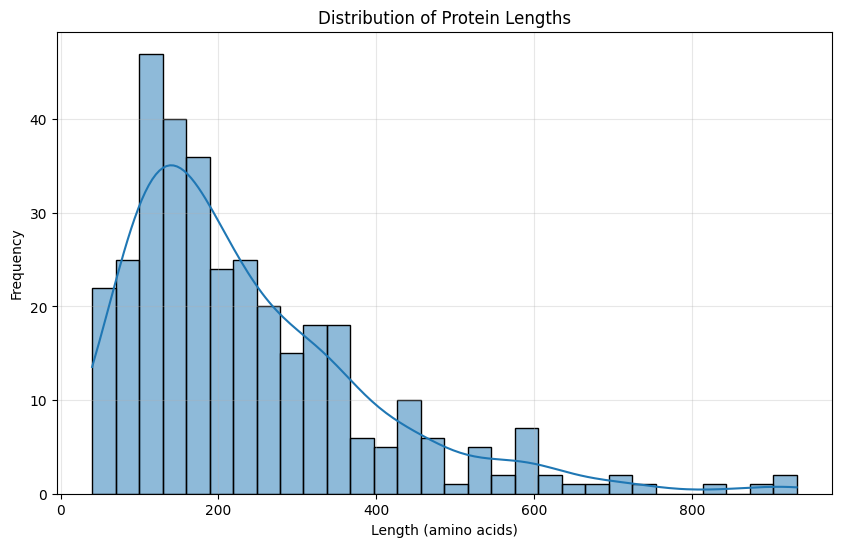

In [19]:
cls.plot_length_distribution()

/tmp/ipykernel_612084/281375845.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(


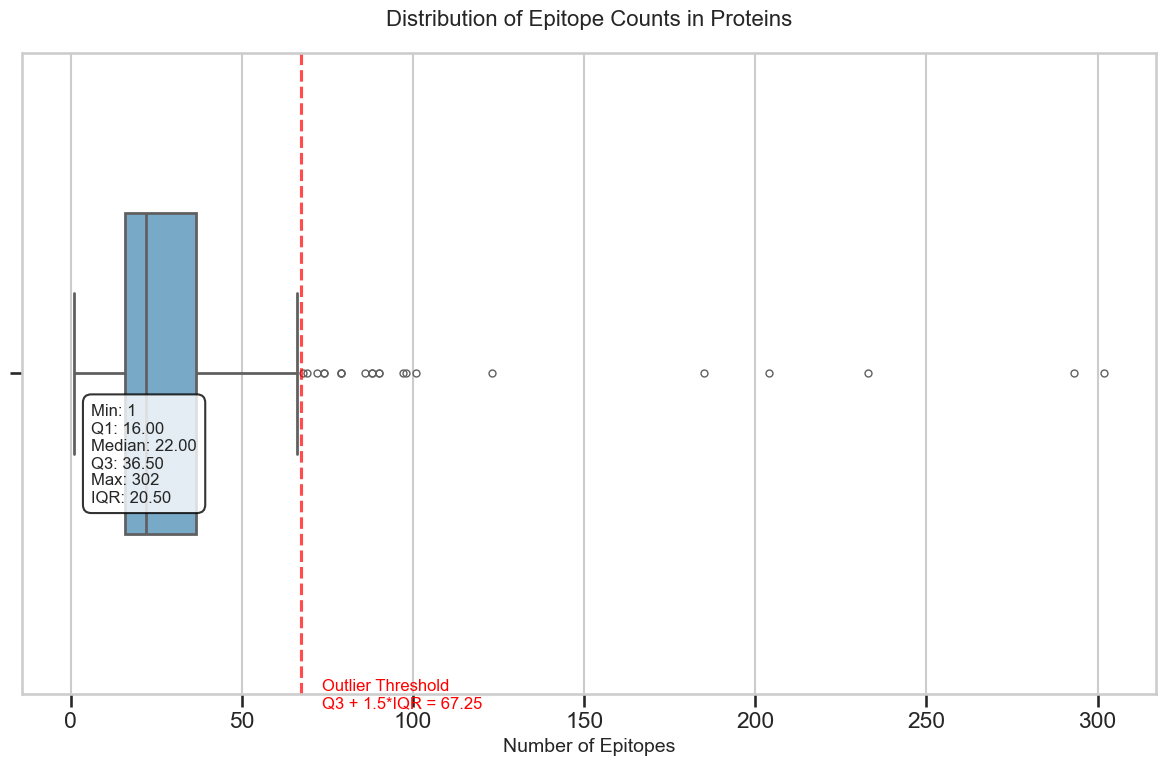

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Epitope Counts in Proteins'}, xlabel='Number of Epitopes'>)

In [20]:
cls.plot_epitope_boxplot()

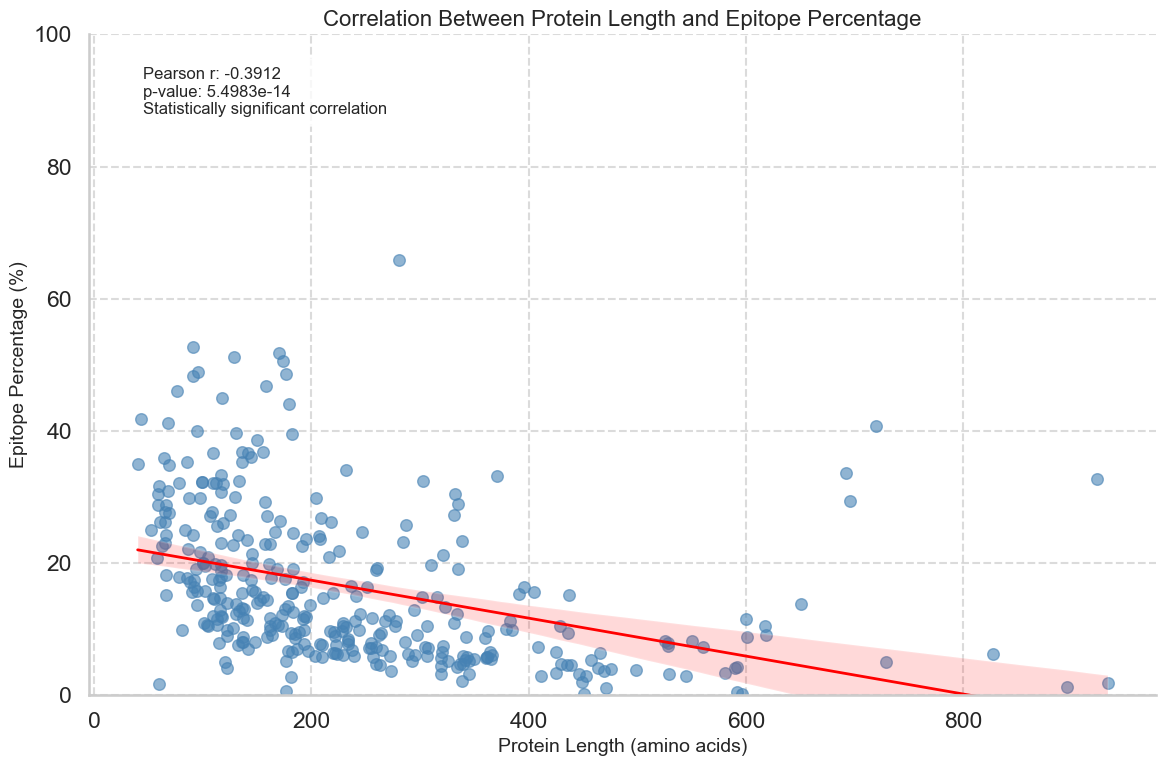

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
cls.plot_length_vs_epitope()

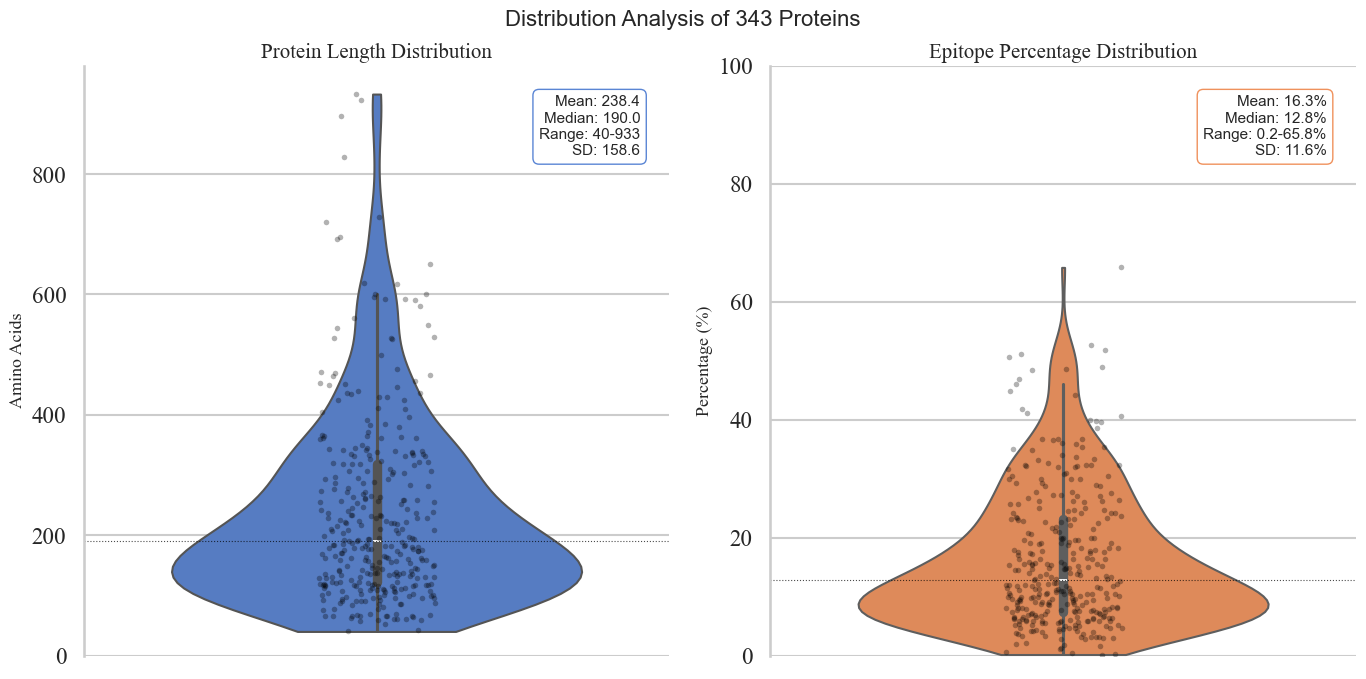

In [22]:
fig1 = cls.plot_length_epitope_violin()

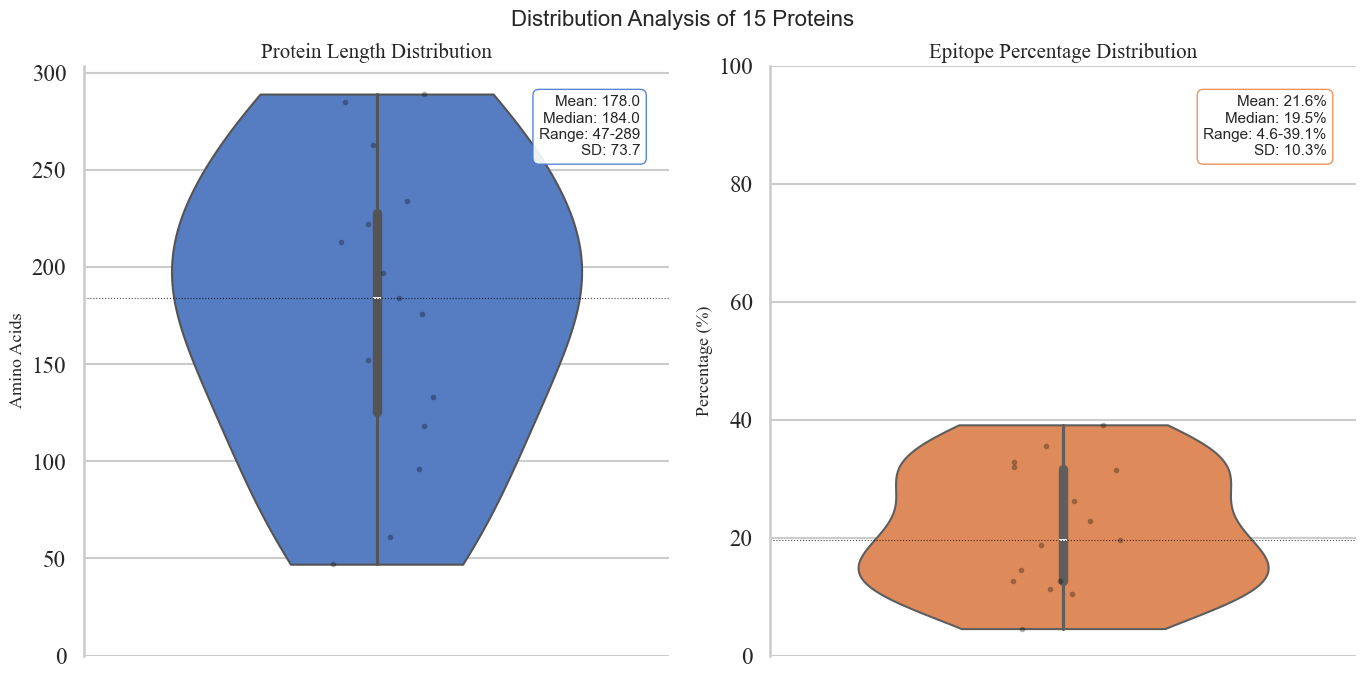

In [23]:
fig1_test = cls_test.plot_length_epitope_violin()

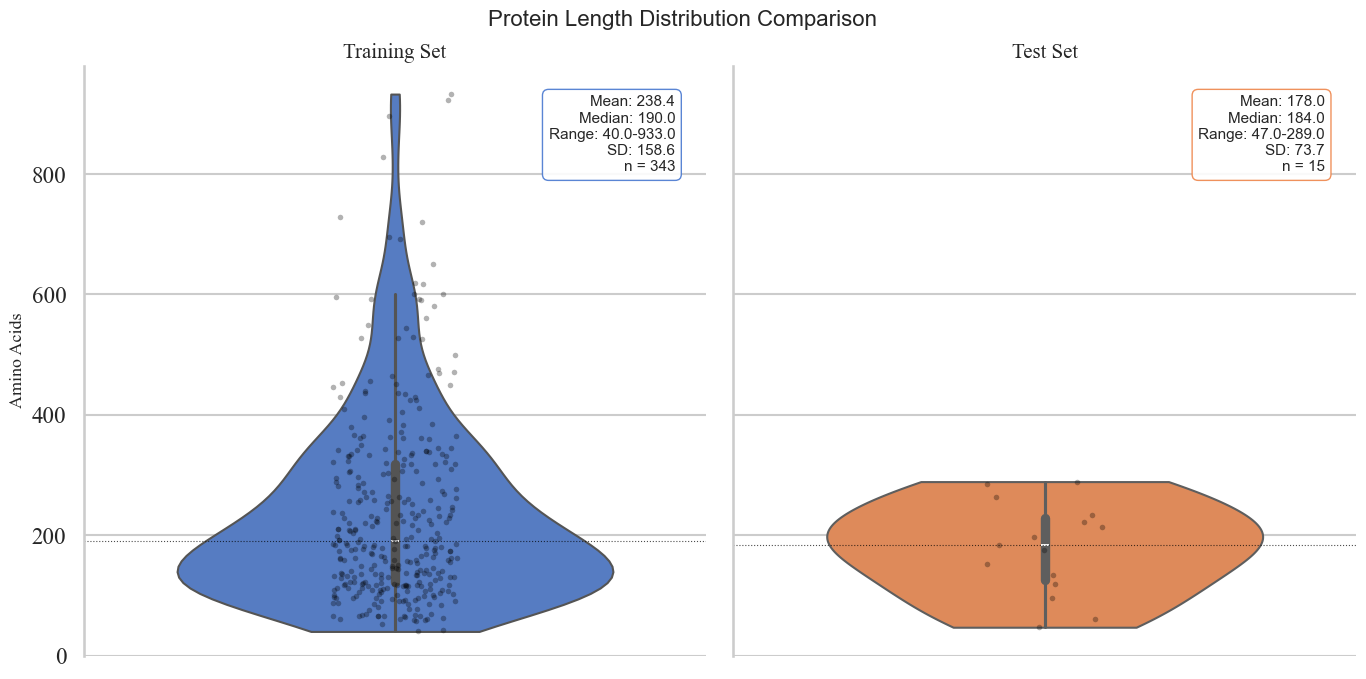

In [24]:
fig2 = cls.compare_datasets_violin(cls_test, metric='length')

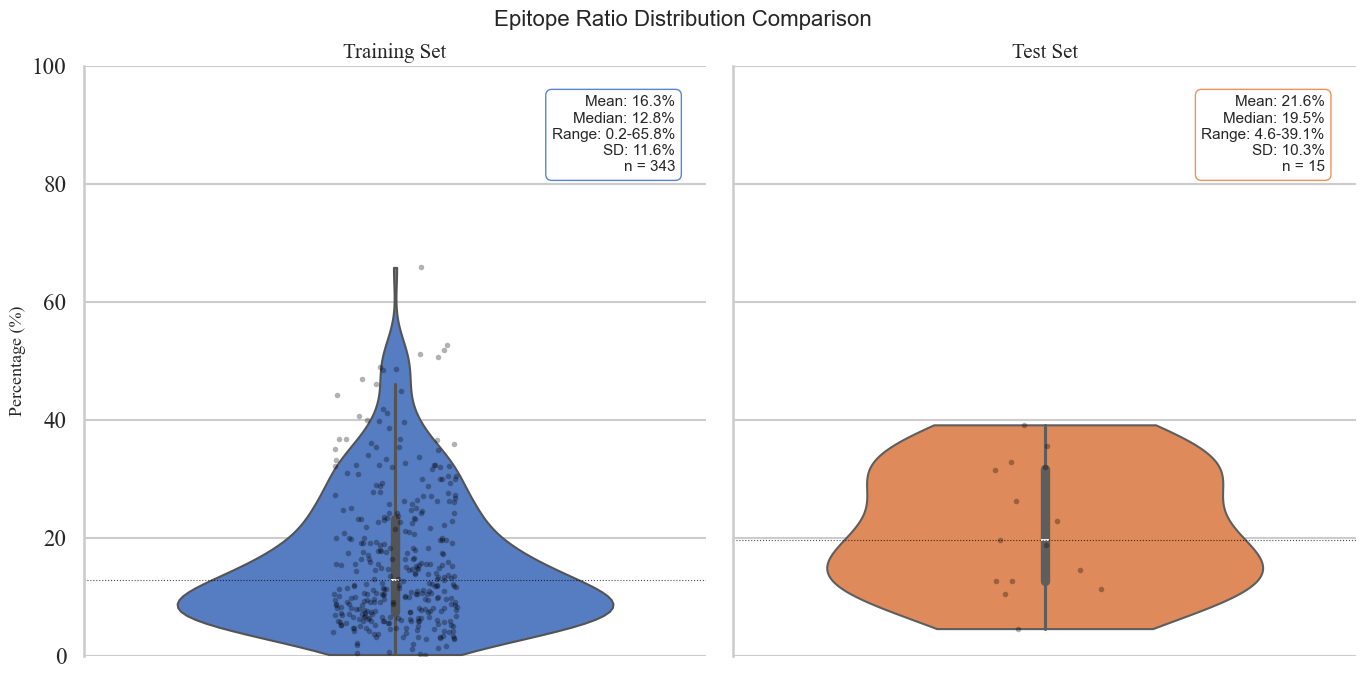

In [25]:
fig2_test = cls.compare_datasets_violin(cls_test, metric='epitope_percentage') 

Epitope Ratio Comparison:
Training Set: 13.26% (10841 epitopes in 81769 amino acids)
Test Set: 18.99% (507 epitopes in 2670 amino acids)
Combined: 13.44% (11348 epitopes in 84439 amino acids)
Statistical Test: Significant difference (p=0.0363)


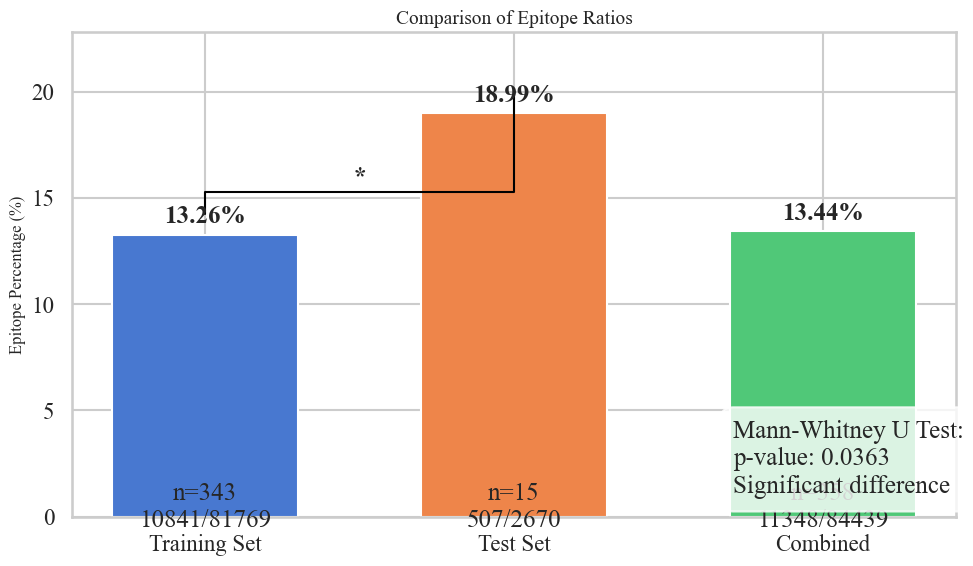

In [26]:
results = cls.compare_epitope_ratios(cls_test)


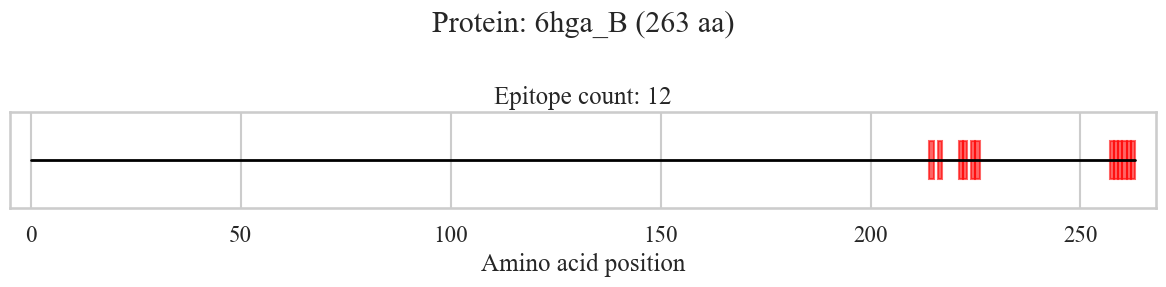

(<Figure size 1200x300 with 1 Axes>,
 <Axes: title={'center': 'Epitope count: 12'}, xlabel='Amino acid position'>)

In [27]:
cls_test.visualize_sequence('6hga_B')

/tmp/ipykernel_612084/2326021852.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_sorted_by_pct['Amino Acid'], fontsize=12, fontweight='bold')


Overall B-cell epitope percentage: 13.26%
Total residues analyzed: 81,769
Epitope residues (uppercase): 10,841
Non-epitope residues (lowercase): 70,928


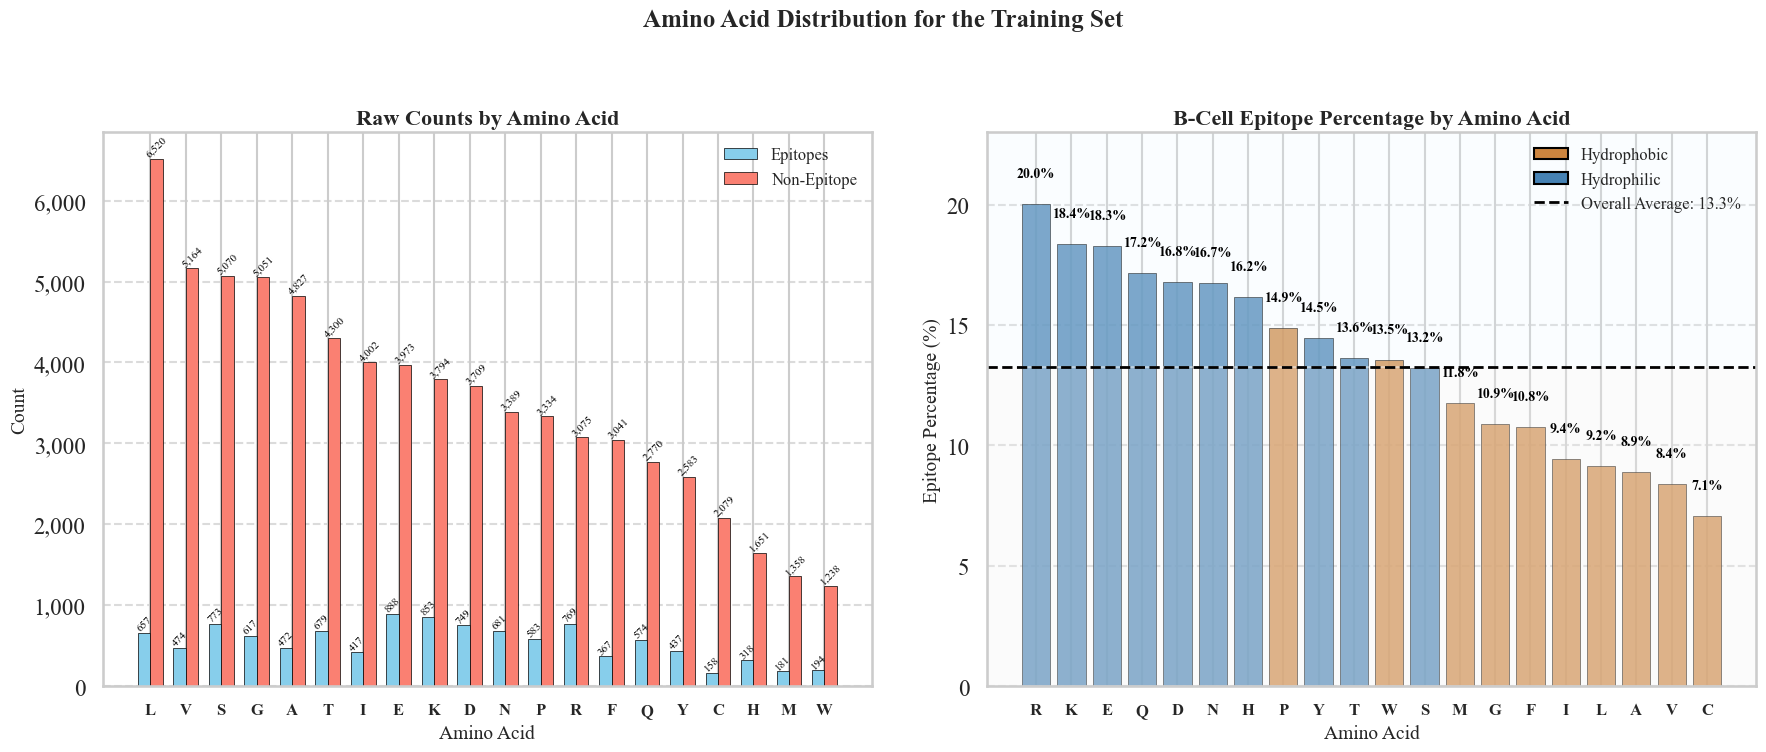

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Define EXACTLY ONE color for each category
HYDROPHOBIC_COLOR = '#CD853F'  # Brown
HYDROPHILIC_COLOR = '#4682B4'  # Blue

# Define amino acid properties with CONSISTENT colors
aa_properties = {
    # Hydrophobic - ALL same color
    'A': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Alanine
    'C': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Cysteine
    'F': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Phenylalanine
    'G': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Glycine
    'I': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Isoleucine
    'L': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Leucine
    'M': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Methionine
    'P': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Proline
    'V': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Valine
    'W': {'type': 'hydrophobic', 'color': HYDROPHOBIC_COLOR},  # Tryptophan
    
    # Hydrophilic - ALL same color
    'D': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Aspartic acid
    'E': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Glutamic acid
    'H': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Histidine
    'K': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Lysine
    'N': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Asparagine
    'Q': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Glutamine
    'R': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Arginine
    'S': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Serine
    'T': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Threonine
    'Y': {'type': 'hydrophilic', 'color': HYDROPHILIC_COLOR},  # Tyrosine
}

def visualize_amino_acid_case_distribution(data):
    # Initialize counter dictionaries
    aa_counts = {aa: {'upper': 0, 'lower': 0} for aa in amino_acids}
    
    # Process each protein sequence
    total_upper = 0
    total_lower = 0
    
    for prot_key in data.keys():
        if 'sequence' not in data[prot_key]:
            continue
            
        sequence = data[prot_key]['sequence']
        
        for residue in sequence:
            upper_residue = residue.upper()
            if upper_residue not in amino_acids:
                continue
                
            if residue.isupper():
                aa_counts[upper_residue]['upper'] += 1
                total_upper += 1
            else:
                aa_counts[upper_residue]['lower'] += 1
                total_lower += 1
    
    # Create a DataFrame for visualization
    df_data = []
    for aa in amino_acids:
        upper = aa_counts[aa]['upper']
        lower = aa_counts[aa]['lower']
        total = upper + lower
        
        if total > 0:
            upper_pct = (upper / total) * 100
            # Calculate 95% confidence interval
            ci = 1.96 * np.sqrt((upper_pct * (100 - upper_pct)) / total) if total >= 10 else 0
                
            df_data.append({
                'Amino Acid': aa,
                'Epitope Count': upper,
                'Non-Epitope Count': lower,
                'Total Count': total,
                'Uppercase Percentage': upper_pct,
                'Confidence Interval': ci,
                'Property': aa_properties[aa]['type'],
                'Color': aa_properties[aa]['color']
            })
    
    df = pd.DataFrame(df_data)
    
    # Create figure with only two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Raw counts plot
    ax1.set_title('Raw Counts by Amino Acid', fontsize=16, fontweight='bold')
    
    x = np.arange(len(df))
    width = 0.35
    
    # Sort by total count for the raw counts plot
    df_sorted_by_total = df.sort_values('Non-Epitope Count', ascending=False).reset_index(drop=True)
    
    bars1 = ax1.bar(x - width/2, df_sorted_by_total['Epitope Count'], width, label='Epitopes', color='skyblue', edgecolor='black', linewidth=0.5)
    bars2 = ax1.bar(x + width/2, df_sorted_by_total['Non-Epitope Count'], width, label='Non-Epitope', color='salmon', edgecolor='black', linewidth=0.5)
    
    # Add count labels above each bar
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=8,
                    rotation=45, color='black')
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=8,
                    rotation=45, color='black')
    
    ax1.set_xlabel('Amino Acid', fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_sorted_by_total['Amino Acid'], fontsize=12, fontweight='bold')
    ax1.legend(fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Format y-axis with commas for thousands
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
    
    # Uppercase percentage plot with hydrophobicity coloring
    ax2.set_title('B-Cell Epitope Percentage by Amino Acid', fontsize=16, fontweight='bold')
    
    # Sort by uppercase percentage for this plot
    df_sorted_by_pct = df.sort_values('Uppercase Percentage', ascending=False).reset_index(drop=True)
    
    # Calculate overall percentage for reference line
    overall_upper_pct = (total_upper / (total_upper + total_lower)) * 100
    
    # Get colors from the amino acid properties
    colors = df_sorted_by_pct['Color'].tolist()
    
    # Bar chart with error bars for confidence intervals
    bars = ax2.bar(df_sorted_by_pct['Amino Acid'], df_sorted_by_pct['Uppercase Percentage'],
                   color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)
    
    # Add percentage labels above each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = df_sorted_by_pct['Uppercase Percentage'].iloc[i]
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{percentage:.1f}%',
                 ha='center', va='bottom', fontsize=10,
                 rotation=0, color='black', fontweight='bold')
    
    # Add reference line for overall percentage
    ax2.axhline(y=overall_upper_pct, color='black', linestyle='--', linewidth=2,
                label=f'Overall Average: {overall_upper_pct:.1f}%')
    
    ax2.set_xlabel('Amino Acid', fontsize=14)
    ax2.set_ylabel('Epitope Percentage (%)', fontsize=14)
    ax2.set_ylim(0, min(110, max(df_sorted_by_pct['Uppercase Percentage']) * 1.15))
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Create custom legend for hydrophobic/hydrophilic properties
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=HYDROPHOBIC_COLOR, edgecolor='black', label='Hydrophobic'),
        Patch(facecolor=HYDROPHILIC_COLOR, edgecolor='black', label='Hydrophilic'),
        plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label=f'Overall Average: {overall_upper_pct:.1f}%')
    ]
    
    ax2.legend(handles=legend_elements, fontsize=12, loc='upper right')
    ax2.set_xticklabels(df_sorted_by_pct['Amino Acid'], fontsize=12, fontweight='bold')
    
    # Add a background color to distinguish bars above and below average
    plt.axhspan(0, overall_upper_pct, facecolor='#f2f2f2', alpha=0.3)
    plt.axhspan(overall_upper_pct, ax2.get_ylim()[1], facecolor='#e6f7ff', alpha=0.2)
    
    # Main title for the figure
    fig.suptitle('Amino Acid Distribution for the Training Set', fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.15)
    
    plt.savefig('amino_acid_case_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig('amino_acid_case_distribution.pdf', bbox_inches='tight')
    
    # Print summary statistics
    print(f"Overall B-cell epitope percentage: {overall_upper_pct:.2f}%")
    print(f"Total residues analyzed: {total_upper + total_lower:,}")
    print(f"Epitope residues (uppercase): {total_upper:,}")
    print(f"Non-epitope residues (lowercase): {total_lower:,}")
    
    return fig, df

# Example of how to use the function:
fig, df = visualize_amino_acid_case_distribution(data)

In [35]:
def analyze_amino_acid_case(data):
    # Initialize dictionary to track statistics for each amino acid
    aa_case_stats = {aa: {'uppercase_count': 0, 'lowercase_count': 0, 'total_count': 0} for aa in amino_acids}
    
    # Track statistics per protein
    protein_stats = {}
    
    # Process each protein sequence
    for prot_key in data.keys():
        if 'sequence' not in data[prot_key]:
            print(f"Warning: No sequence found for protein {prot_key}")
            continue
            
        residues = list(data[prot_key]['sequence'])
        
        # Track stats for this protein
        uppercase_residues = []
        lowercase_residues = []
        all_residues = []
        
        for residue in residues:
            # Get the uppercase version for standardization
            upper_residue = residue.upper()
            
            # Skip if not a standard amino acid
            if upper_residue not in amino_acids:
                continue
                
            all_residues.append(upper_residue)
            
            # Update the global stats dictionary
            aa_case_stats[upper_residue]['total_count'] += 1
            
            # Check if uppercase or lowercase
            if residue.isupper():
                aa_case_stats[upper_residue]['uppercase_count'] += 1
                uppercase_residues.append(upper_residue)
            else:
                aa_case_stats[upper_residue]['lowercase_count'] += 1
                lowercase_residues.append(upper_residue)
        
        # Store protein-specific stats
        protein_stats[prot_key] = {
            'length': len(residues),
            'uppercase_count': len(uppercase_residues),
            'lowercase_count': len(lowercase_residues),
            'uppercase_percentage': (len(uppercase_residues) / len(residues)) * 100 if residues else 0,
            'uppercase_residues': uppercase_residues,
            'lowercase_residues': lowercase_residues,
            'all_residues': all_residues
        }
    
    # Calculate percentages for each amino acid
    for aa in amino_acids:
        total = aa_case_stats[aa]['total_count']
        if total > 0:
            aa_case_stats[aa]['uppercase_percentage'] = (aa_case_stats[aa]['uppercase_count'] / total) * 100
            aa_case_stats[aa]['lowercase_percentage'] = (aa_case_stats[aa]['lowercase_count'] / total) * 100
    
    # Calculate overall statistics
    total_residues = sum(stats['total_count'] for stats in aa_case_stats.values())
    total_uppercase = sum(stats['uppercase_count'] for stats in aa_case_stats.values())
    
    overall_stats = {
        'total_residues': total_residues,
        'total_uppercase': total_uppercase,
        'total_lowercase': total_residues - total_uppercase,
        'uppercase_percentage': (total_uppercase / total_residues) * 100 if total_residues else 0
    }
    
    return {
        'amino_acid_stats': aa_case_stats,
        'protein_stats': protein_stats,
        'overall_stats': overall_stats
    }
 
result = analyze_amino_acid_case(data)
print(f"Overall uppercase percentage: {result['overall_stats']['uppercase_percentage']:.2f}%")

Overall uppercase percentage: 13.26%


# Preprocessing the data

In [27]:
preprocessed_data = {}

def prepare_data(protein_data):
    """
    Convert data to dictionary with protein name as key and nested dictionary containing upper-cased sequence and epitope labels
    """
    protein_sequence = []
    epitope_labels = []
    protein_name = []

    for name, data in protein_data.items():
        sequence = data['sequence']

        protein_sequence.append(sequence.upper())
        protein_name.append(name)

        epitope_labels.append([1 if aa.isupper() else 0 for aa in sequence])

    return protein_name, protein_sequence, epitope_labels
name, seq, label = prepare_data(data)

preprocessed_data = {}
for i, nam in enumerate(name):
    preprocessed_data[nam] = {
        'sequence': seq[i],
        'labels': label[i]
    }

In [ ]:
preprocessed_data

### Test Data

In [29]:
preprocessed_test_data = {}

def prepare_data(protein_data):
    """
    Convert data to dictionary with protein name as key and nested dictionary containing upper-cased sequence and epitope labels
    """
    protein_sequence = []
    epitope_labels = []
    protein_name = []

    for name, data in protein_data.items():
        sequence = data['sequence']

        protein_sequence.append(sequence.upper())
        protein_name.append(name)

        epitope_labels.append([1 if aa.isupper() else 0 for aa in sequence])

    return protein_name, protein_sequence, epitope_labels
name, seq, label = prepare_data(test_data)

preprocessed_test_data = {}
for i, nam in enumerate(name):
    preprocessed_test_data[nam] = {
        'sequence': seq[i],
        'labels': label[i]
    }

In [ ]:
preprocessed_test_data

### HDF5 File Generation

### ESM2

In [ ]:
esm2_650m = "facebook/esm2_t33_650M_UR50D"

def esm2_gen_hdf5(protein_data, model_name, output_file):
    print(f"[DEBUG] Writing HDF5 to: {output_file}") 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    model.eval()

    with h5py.File(output_file, 'w') as f:
        emb_group = f.create_group('embeddings_folder')

        #looping through proteins and generating embeddings
        for name, data in tqdm.tqdm(protein_data.items()):
            sequence = data['sequence']

            #tokenize
            inputs = tokenizer(sequence, return_tensors="pt")
            with torch.no_grad(): #memory usage reduced since not tracking gradients
                outputs = model(**inputs) #using ** to unpack dictionary


            #get last hidden states and using numpy to get shape [sequence_length, embedding_dim]
            embeddings = outputs.last_hidden_state[0].numpy()

            seq_len=len(sequence)
            protein_group = emb_group.create_group(name)
            protein_group.create_dataset('embeddings', data = embeddings[1:seq_len+1])
            protein_group.create_dataset('labels', data = np.array(data['labels']))

            protein_group.attrs['sequence'] = sequence
            protein_group.attrs['length'] = seq_len

###ONLY RUN THIS ONCE
esm2_gen_hdf5(preprocessed_data, esm2_650m, "esm2_protein_embeddings.h5")

#### Test data

In [ ]:
esm2_gen_hdf5(preprocessed_test_data, esm2_650m, "esm2_test_protein_embeddings.h5")

### ESMC

In [15]:
import esm
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from torch.nn import *

In [ ]:
def esmc_gen_hdf5(protein_data, output_file):
    client = ESMC.from_pretrained('esmc_300m').to("cpu")
    client.eval()

    with h5py.File(output_file, 'w') as f:
        emb_group = f.create_group('embeddings_folder')

        for name, data in tqdm.tqdm(protein_data.items()):
            sequence = data['sequence']

            input_protein = ESMProtein(sequence)

            with torch.no_grad():
                tensor = client.encode(input_protein)
                logits_output = client.logits(tensor, LogitsConfig(sequence=True, return_embeddings=True))
                embeddings = logits_output.embeddings[0].to(torch.float32).numpy()

            protein_group = emb_group.create_group(name)
            protein_group.create_dataset('embeddings', data = embeddings[1:-1])
            protein_group.create_dataset('labels', data = np.array(data['labels']))

            protein_group.attrs['sequence'] = sequence
            protein_group.attrs['length'] = len(sequence)

#ONLY RUN THIS ONCE
esmc_gen_hdf5(preprocessed_data, 'esmc_protein_embeddings.h5')

In [ ]:
esmc_gen_hdf5(preprocessed_test_data, 'esmc_test_protein_embeddings.h5')

In [ ]:
## how long does it tak to obtain the embeddings for all proteins?
client = ESMC.from_pretrained('esmc_300m').to("cpu")
client.eval()
for name, data in tqdm.tqdm(preprocessed_data.items()):
    sequence = data['sequence']
    input_protein = ESMProtein(sequence)

    with torch.no_grad():
        tensor = client.encode(input_protein)
        logits_output = client.logits(tensor, LogitsConfig(sequence=True, return_embeddings=True))
        embeddings = logits_output.embeddings[0].to(torch.float32).numpy()